# Project 3: Web API & NLP Modeling and Model Evaluation

## Libraries Importing

In [91]:
# Import standard libraries
import requests
import pandas as pd
import numpy as np
import time
import random
import seaborn as sns
import matplotlib.pyplot as plt

# Import scikit learn libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier

# Import natural language processing relevant libraries 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import spacy

# Load English model and instantiate
nlp = spacy.load("en_core_web_sm")


## Data Importing

In [2]:
# Import the tokenized df and view the data
df_tokenized = pd.read_csv('Data/tokenized_df.csv')
df_tokenized.head()

,mapped_subreddit,text,title,post,tokenized,tokenized_nostop,tokenized_lemma,tokenized_lemma_nostop
0,1,"Hey, /r/disneyland. I think I'll try and post ...",[Poll] Is this ok?,"Hey, /r/disneyland. I think I'll try and post ...","hey , /r/. i think i 'll try and post cool p...",i i 'll and on here every once in a do you thi...,"hey , /r/. I think I 'll try and post cool p...",I I 'll and on here every once in a do you thi...
1,1,"So, what's YOUR favorite land in Disneyland?",Favorite Land?,"So, what's YOUR favorite land in Disneyland?Fa...","so , what 's your favorite land in ? favorite ...",so what 's your in,"so , what be your favorite land in ? Favorite ...",so what be your in
2,1,Hey everyone! I don't know if you're allowed t...,Does anyone have any pictures from inside club...,Hey everyone! I don't know if you're allowed t...,hey everyone ! i do n't know if you 're allowe...,everyone i do n't if you 're to take in there ...,hey everyone ! I do n't know if you be allow t...,everyone I do n't if you be to take in there o...
3,1,I love Bert and Mary. I think it's something a...,Who is your favorite face character?,I love Bert and Mary. I think it's something a...,i love bert and mary . i think it 's something...,i and i it 's something about them being than ...,I love Bert and Mary . I think it be something...,I and I it be something about they be than or ...
4,1,"I have an interview Friday, and I'd like to kn...",Does Disneyland drug test employees? (x-post f...,"I have an interview Friday, and I'd like to kn...","i have an interview friday , and i 'd like to ...",i have an and i 'd to if before i do n't any i...,"I have an interview Friday , and I would like ...",I have an and I would to if before I do n't an...


In [3]:
# Bootstrapping universalstudios data 

# Concating 2000 universalstudios samples to the existing df
df_bootstrapped = pd.concat([df_tokenized, df_tokenized[df_tokenized['mapped_subreddit']==0].sample(2000, replace=True)])
df_bootstrapped.head()

,mapped_subreddit,text,title,post,tokenized,tokenized_nostop,tokenized_lemma,tokenized_lemma_nostop
0,1,"Hey, /r/disneyland. I think I'll try and post ...",[Poll] Is this ok?,"Hey, /r/disneyland. I think I'll try and post ...","hey , /r/. i think i 'll try and post cool p...",i i 'll and on here every once in a do you thi...,"hey , /r/. I think I 'll try and post cool p...",I I 'll and on here every once in a do you thi...
1,1,"So, what's YOUR favorite land in Disneyland?",Favorite Land?,"So, what's YOUR favorite land in Disneyland?Fa...","so , what 's your favorite land in ? favorite ...",so what 's your in,"so , what be your favorite land in ? Favorite ...",so what be your in
2,1,Hey everyone! I don't know if you're allowed t...,Does anyone have any pictures from inside club...,Hey everyone! I don't know if you're allowed t...,hey everyone ! i do n't know if you 're allowe...,everyone i do n't if you 're to take in there ...,hey everyone ! I do n't know if you be allow t...,everyone I do n't if you be to take in there o...
3,1,I love Bert and Mary. I think it's something a...,Who is your favorite face character?,I love Bert and Mary. I think it's something a...,i love bert and mary . i think it 's something...,i and i it 's something about them being than ...,I love Bert and Mary . I think it be something...,I and I it be something about they be than or ...
4,1,"I have an interview Friday, and I'd like to kn...",Does Disneyland drug test employees? (x-post f...,"I have an interview Friday, and I'd like to kn...","i have an interview friday , and i 'd like to ...",i have an and i 'd to if before i do n't any i...,"I have an interview Friday , and I would like ...",I have an and I would to if before I do n't an...


**Reason for utilizing bootstrapping**
- Because of the imbalance of the data between 2 classes where Disney has almost 2 times more data than Universal, Bootstrapping is then implemented for increasing the universal data to be at the same level as Disney
- Bootstrapping is done by randomly sampled 2000 rows from Universal subreddit and concat them to df_tokenized

## Data Assigning 

**Reason for choosing tokenized_lemma column**
- Even though tokenized_lemma_nostop would be the most suitable option, but once tested out with top words procedure, the outcome of the top word rank was not distinct for classification at all
- As a result, tokenized_lemma is the chosen column, stop_words removal are applied individually later in the model

In [4]:
# Assign tokenized & lemmatized post to X and mapped subreddit to y
X = df_tokenized['tokenized_lemma']
y = df_tokenized['mapped_subreddit']

In [5]:
# Assign tokenized & lemmatized bootstrapped data to X_bootstrapped and mapped subreddit bootstrapped data to y bootstrapped
X_bootstrapped = df_bootstrapped['tokenized_lemma']
y_bootstrapped = df_bootstrapped['mapped_subreddit']

## Top Words: Post-Data Cleaning

- Another rank of top words are performed once again after the text data had been pre-processed. This is to see if stop words or target words have been removed, or whether the outcome of the rank has changed
- Overall, target words are removed, however; some irrelevant words are still appear on the list after top words removal

### Diney: 1-gram Top Words

In [6]:
# Set up CountVectorizer with a parameter that removes stop_words
cvec = CountVectorizer(stop_words='english')

# Fit Disneyland's tokenized & lemmatized posts
cvec.fit(df_tokenized.loc[df_tokenized['mapped_subreddit']==1]['tokenized_lemma'])

# Transform Disneyland's tokenized & lemmatized posts
disney_post_cvec = cvec.transform(df_tokenized.loc[df_tokenized['mapped_subreddit']==1]['tokenized_lemma'])

# Change the transformed posts into a dense matrix, then creating a dataframe with the dense matrix with columns names which are the unique words presented in the data
disney_cvec_df = pd.DataFrame(disney_post_cvec.todense(), columns=cvec.get_feature_names_out())

# Create the dataframe that sorts the top 15 most occurences words
disney_top_words = pd.DataFrame(disney_cvec_df.sum().sort_values(ascending=False).head(15), columns = ['Count'])
disney_top_words

,Count
park,2313
day,2083
time,1957
just,1710
know,1588
ride,1440
like,1332
want,1166
year,1103
pass,986


### Disney: 2-gram Top Words

In [7]:
# Set up CountVectorizer with a parameter that removes stop_words and consider only 2 adjecent words
cvec_bigrams = CountVectorizer(ngram_range=(2, 2), stop_words='english')

# Fit Disneyland's bigrammed tokenized & lemmatized posts
cvec_bigrams.fit(df_tokenized.loc[df_tokenized['mapped_subreddit']==1]['tokenized_lemma'])

# Transform Disneyland's bigrammed tokenized & lemmatized posts
bigrams_cvec = cvec_bigrams.transform(df_tokenized.loc[df_tokenized['mapped_subreddit']==1]['tokenized_lemma'])

# Change the transformed posts into a dense matrix, then creating a dataframe with the dense matrix with columns names which are the unique words presented in the data
bigrams_df = pd.DataFrame(bigrams_cvec.todense(), columns=cvec_bigrams.get_feature_names_out())

# Create the dataframe that sorts the top 15 most occurences words bigrammed words
disney_top_biwords = pd.DataFrame(bigrams_df.sum().sort_values(ascending=False).head(15), columns = ['Count'])
disney_top_biwords

,Count
cast member,340
annual pass,234
california adventure,219
fast pass,188
day park,181
year old,164
space mountain,160
park hopper,154
world color,153
halloween party,142


### Disney: 3-gram Top Words

In [8]:
# Set up CountVectorizer with a parameter that removes stop_words and consider only 3 adjacent words
cvec_trigrams = CountVectorizer(ngram_range=(3, 3), stop_words='english')

# Fit Disneyland's trigrammed tokenized & lemmatized posts
cvec_trigrams.fit(df_tokenized.loc[df_tokenized['mapped_subreddit']==1]['tokenized_lemma'])

# Transform Disneyland's bigrammed tokenized & lemmatized posts
trigrams_cvec = cvec_trigrams.transform(df_tokenized.loc[df_tokenized['mapped_subreddit']==1]['tokenized_lemma'])

# Change the transformed posts into a dense matrix, then creating a dataframe with the dense matrix with columns names which are the unique words presented in the data
trigrams_df = pd.DataFrame(trigrams_cvec.todense(), columns=cvec_trigrams.get_feature_names_out())

# Create the dataframe that sorts the top 15 most occurences words trigrammed words
disney_top_triwords = pd.DataFrame(trigrams_df.sum().sort_values(ascending=False).head(15), columns = ['Count'])
disney_top_triwords

,Count
day park hopper,76
mickey halloween party,53
star wars land,39
radiator springs racers,32
park hopper ticket,29
want make sure,27
annual pass holder,26
new orleans square,24
single rider line,24
park hopper pass,23


### Universal: 1-gram Top Words

In [9]:
# Set up CountVectorizer with a parameter that removes stop_words 
cvec = CountVectorizer(stop_words='english')

# Fit Universalstudio's tokenized & lemmatized posts
cvec.fit(df_tokenized.loc[df_tokenized['mapped_subreddit']==0]['tokenized_lemma'])

# Transform Universalstudio's tokenized & lemmatized posts
universal_post_cvec = cvec.transform(df_tokenized.loc[df_tokenized['mapped_subreddit']==0]['tokenized_lemma'])

# Change the transformed posts into a dense matrix, then creating a dataframe with the dense matrix with columns names which are the unique words presented in the data
universal_cvec_df = pd.DataFrame(universal_post_cvec.todense(), columns=cvec.get_feature_names_out())

# Create the dataframe that sorts the top 15 most occurences words trigrammed words
universal_top_words = pd.DataFrame(universal_cvec_df.sum().sort_values(ascending=False).head(15), columns = ['Count'])
universal_top_words

,Count
park,1043
day,941
ride,880
pass,785
time,710
ticket,629
know,510
just,506
like,456
want,433


### Universal: 2-gram Top Words

In [10]:
# Set up CountVectorizer with a parameter that removes stop_words and consider only 2 adjacent words
cvec_bigrams = CountVectorizer(ngram_range=(2, 2), stop_words='english')

# Fit Universalstudio's tokenized & lemmatized posts
cvec_bigrams.fit(df_tokenized.loc[df_tokenized['mapped_subreddit']==0]['tokenized_lemma'])

# Transform Universalstudio's tokenized & lemmatized posts
bigrams_cvec = cvec_bigrams.transform(df_tokenized.loc[df_tokenized['mapped_subreddit']==0]['tokenized_lemma'])

# Change the transformed posts into a dense matrix, then creating a dataframe with the dense matrix with columns names which are the unique words presented in the data
bigrams_df = pd.DataFrame(bigrams_cvec.todense(), columns=cvec_bigrams.get_feature_names_out())

# Create the dataframe that sorts the top 15 most occurences words bigrammed words
universal_top_biwords = pd.DataFrame(bigrams_df.sum().sort_values(ascending=False).head(15), columns = ['Count'])
universal_top_biwords

,Count
express pass,241
harry potter,214
nintendo world,128
annual pass,125
studios hollywood,115
super nintendo,104
theme park,84
wait time,71
buy ticket,70
day park,65


### Universal: 3-gram Top Words

In [11]:
# Set up CountVectorizer with a parameter that removes stop_words and consider only 3 adjacent words
cvec_trigrams = CountVectorizer(ngram_range=(3, 3), stop_words='english')

# Fit Universalstudio's tokenized & lemmatized posts
cvec_trigrams.fit(df_tokenized.loc[df_tokenized['mapped_subreddit']==0]['tokenized_lemma'])

# Transform Universalstudio's tokenized & lemmatized posts
trigrams_cvec = cvec_trigrams.transform(df_tokenized.loc[df_tokenized['mapped_subreddit']==0]['tokenized_lemma'])

# Change the transformed posts into a dense matrix, then creating a dataframe with the dense matrix with columns names which are the unique words presented in the data
trigrams_df = pd.DataFrame(trigrams_cvec.todense(), columns=cvec_trigrams.get_feature_names_out())

# Create the dataframe that sorts the top 15 most occurences words trigrammed words
universal_top_triwords = pd.DataFrame(trigrams_df.sum().sort_values(ascending=False).head(15), columns = ['Count'])
universal_top_triwords

,Count
super nintendo world,95
halloween horror nights,36
harry potter world,28
day park park,22
halloween horror night,22
buy express pass,18
jurassic park ride,18
harry potter fan,16
world harry potter,15
harry potter ride,15


## Training and Testing Data Splitting

In [12]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [13]:
# Split the bootstrapped data into the training and testing sets.
X_train_boot, X_test_boot, y_train_boot, y_test_boot = train_test_split(X_bootstrapped,
                                                    y_bootstrapped,
                                                    test_size=0.33,
                                                    random_state=42)

## Baseline Accuracy

In [88]:
# See the distribution of normalized data and baseline accuracy
y.value_counts(normalize=True).round(2)

mapped_subreddit
1    0.72
0    0.28
Name: proportion, dtype: float64

In [89]:
# See the distribution of normalized bootstrapped data and baseline accuracy
y_bootstrapped.value_counts(normalize=True).round(2)

mapped_subreddit
1    0.52
0    0.48
Name: proportion, dtype: float64

## Model1: CountVectorizer + Logistic Regression (Original)

In [16]:
# Set up the pipeline of CountVecotizer and Logistic Regression combined with parameters obtained from GridSearch in model2
pipe = Pipeline([
    ('cvec', CountVectorizer(max_features=5000, max_df=0.95, ngram_range=(1, 1), stop_words='english')),
    ('logreg', LogisticRegression(C=1, solver='liblinear'))
])

In [17]:
# Fit the pipeline to Training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.95, max_features=5000,
                                 stop_words='english')),
                ('logreg', LogisticRegression(C=1, solver='liblinear'))])

In [18]:
# Retrieve the accuracy score of Training data
pipe.score(X_train, y_train).round(2)

0.99

In [19]:
# Retrieve the accuracy score of Testing data
pipe.score(X_test, y_test).round(2)

0.91

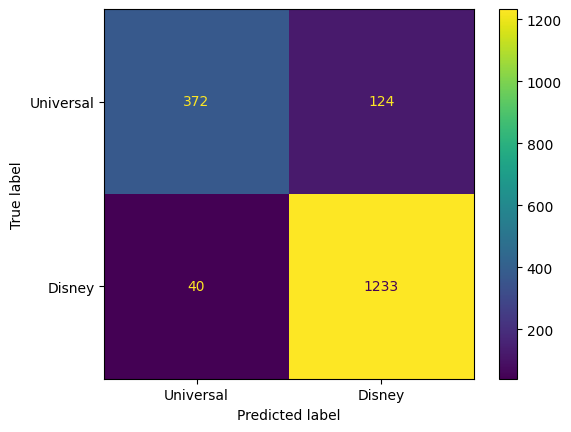

In [20]:
# Get predictions of Testing data
predictions1 = pipe.predict(X_test)

# Set up confusion matrix
dist = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions1),
                              display_labels=['Universal', 'Disney'])
dist.plot();

In [21]:
# Set up the confusion matrix and extract individual score elements

tn1, fp1, fn1, tp1 = confusion_matrix(y_test, predictions1).ravel()
print("True Negatives : ",tn1)
print("False Positives : ",fp1)
print("False Negatives : ", fn1) 
print("True Positives : ", tp1)

True Negatives :  372
False Positives :  124
False Negatives :  40
True Positives :  1233


In [22]:
# Obtain Sensitivity score
print('Sensitivity: ', (tp1/(tp1+fn1)).round(2))

Sensitivity:  0.97


In [23]:
# Obtain Specificity score
print('Specificity: ', (tn1/(tn1+fp1)).round(2))

Specificity:  0.75


In [24]:
# Set up classification report
print(classification_report(y_test, predictions1))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82       496
           1       0.91      0.97      0.94      1273

    accuracy                           0.91      1769
   macro avg       0.91      0.86      0.88      1769
weighted avg       0.91      0.91      0.90      1769



In [25]:
# Set up a dataframe of y_test, prediction, and X_test columns
result_df1 = pd.DataFrame({'true':y_test, 'pred':predictions1, 'post': X_test})

# Set missprediction where y_test is not equal to prediction
missprediction1 = result_df1[result_df1['true']!=result_df1['pred']]
print(missprediction1)

# Save missprediction to csv file
missprediction1.to_csv('missed_predictions1.csv', index=False)

      true  pred                                               post
3907     0     1  decide to head over this weekend for Father 's...
4617     0     1  out of boredom , I be read an article about se...
3952     0     1  for I , it be always to be a skipper on Jake '...
4871     0     1  I be a Travel Nurse currently station at Talla...
3297     1     0  basically what the title say ! last weekend I ...
...    ...   ...                                                ...
1453     1     0  pretty much as the title state . I have try on...
4135     0     1  my fiance and I be gon na be in Florida the we...
1300     1     0  I and my girlfriend be go to   in September fo...
4473     0     1  around when do you think it ’ll open this summ...
4377     0     1  I be at the park frequently if anybody need so...

[164 rows x 3 columns]


**Model Evaluation**
- Training score: 0.99 indicates that the model learned the patterns present in the training data very well
- Testing score: 0.91 indicates the model is able to perform well on outside data
- The model is a little overfit but still can perform on outside data quite well
- Precision score: 0.90 and 0.91 indicates the model correctly predicts the class: Universal 90% and class: Disneyland 91% of the time
- Recall score: 0.75 and 0.97 indicates that the model is able to identify the actual values of class: Universal 75% and class: Disneyland 96% of the time
- F1 score: 0.81 and 0.93 indicates the model good balanced performance on both precision and recall for Disneyland class, but not as good performance for Universal class
- Accuracy score: 0.91 indicates the the model is highly accurate
- Macro avg and Weighted avg: 0.88 and 0.90 indicates good performance of the model
- Incorrectly predict: Universal 15%, Disney 10%
- Out of 1769 posts, 164 posts are incorrectly predicted: 9.27%

**Final Evaluation**
- Model1 is able to perform well with Disneyland class, but in terms of identifying Universal class, the score is still far from Disneyland. Some overfitting of the data is recognized-

## Model2: CountVectorizer + Logistic Regression (Bootstrapped)

In [27]:
# Set up the pipeline of CountVecotizer and Logistic Regression combined with parameters obtained from GridSearch
pipe1 = Pipeline([
    ('cvec', CountVectorizer(max_features=5000, max_df=0.95, ngram_range=(1, 1), stop_words='english')),
    ('logreg', LogisticRegression(C=1, solver='liblinear'))
])

In [28]:
#gs = GridSearchCV(pipe1, 
                  #param_grid=pipe1_params, 
                  #cv=5,
                  #verbose=1)

In [29]:
# Fit the pipeline to Training data bootstrapped data
pipe1.fit(X_train_boot, y_train_boot)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.95, max_features=5000,
                                 stop_words='english')),
                ('logreg', LogisticRegression(C=1, solver='liblinear'))])

In [30]:
#gs.best_score_

In [31]:
#gs.best_params_

In [32]:
# Retrieve the accuracy score of Training bootstrapped data
pipe1.score(X_train_boot, y_train_boot).round(2)

0.99

In [33]:
# Retrieve the accuracy score of Testing bootstrapped data
pipe1.score(X_test_boot, y_test_boot).round(2)

0.95

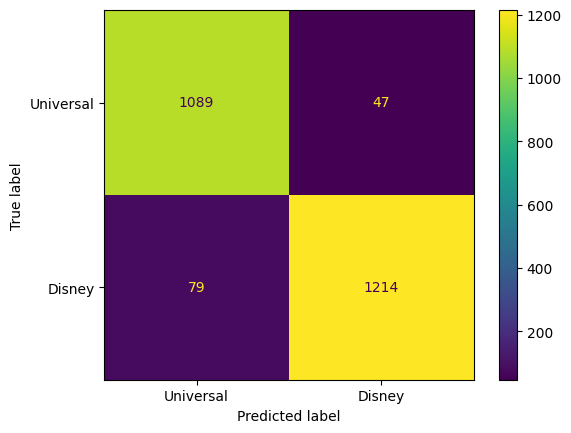

In [34]:
# Get predictions of Testing bootstrapped data
predictions2 = pipe1.predict(X_test_boot)

# Set up confusion matrix
dist = ConfusionMatrixDisplay(confusion_matrix(y_test_boot, predictions2),
                              display_labels=['Universal', 'Disney'])
dist.plot()

In [35]:
# Set up the confusion matrix and extract individual score elements

tn2, fp2, fn2, tp2 = confusion_matrix(y_test_boot, predictions2).ravel()
print("True Negatives : ",tn2)
print("False Positives : ",fp2)
print("False Negatives : ", fn2) 
print("True Positives : ", tp2)

True Negatives :  1089
False Positives :  47
False Negatives :  79
True Positives :  1214


In [36]:
# Obtain Sensitivity score
print('Sensitivity: ', (tp2/(tp2+fn2)).round(2))

Sensitivity:  0.94


In [37]:
# Obtain Specificity score
print('Specificity: ', (tn2/(tn2+fp2)).round(2))

Specificity:  0.96


In [38]:
# Set up classification report

print(classification_report(y_test_boot, predictions2))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1136
           1       0.96      0.94      0.95      1293

    accuracy                           0.95      2429
   macro avg       0.95      0.95      0.95      2429
weighted avg       0.95      0.95      0.95      2429



In [39]:
# Set up a dataframe of y_test, prediction, and X_test columns
result_df2 = pd.DataFrame({'true':y_test_boot, 'pred':predictions2, 'post': X_test_boot})

# Set missprediction where y_test is not equal to prediction
missprediction2 = result_df2[result_df2['true']!=result_df2['pred']]
print(missprediction2)

# Save missprediction to csv file
missprediction2.to_csv('missed_predictions2.csv', index=False)

      true  pred                                               post
1765     1     0  I have n't see anyone mention this yet .   be ...
1544     1     0  my mom be allergic to primarily nut and fish ....
468      1     0  hi all :) \n\n\n my girlfriend and I be plan o...
2698     1     0  I just move here a little bit ago after gradua...
1446     1     0  Hi , all ! \n\n\n I have n't be to the park in...
...    ...   ...                                                ...
71       1     0  my friend and I have park hopper pass for this...
2271     1     0  hello all ! \n\n\n awhile ago , I sign up for ...
1366     1     0  we have a 7:30am reservation at Park Plaza for...
4564     0     1  post in hope that someone that have pull at th...
3966     0     1  my wife and I be head to   Jan 24 - 26 . we be...

[126 rows x 3 columns]


**Model Evaluation**
- Training score: 0.99 indicates that the model learned the patterns present in the data perfectly
- Testing score: 0.95 indicates the model is able to perform very well on outside data
- The model is not overfit and have a close performance between training data and testing data
- Precision score: 0.93 and 0.96 indicates the model correctly predicts the class: Universal 93% and class: Disneyland 96% of the time
- Recall score: 0.96 and 0.94 indicates that the model is able to identify the actual values of class: Universal 96% and class: Disneyland 94% of the time
- F1 score: 0.95 and 0.95 indicates the model well balanced performance on both precision and recall and the score are matched between these 2 classes.
- Accuracy score: 0.95 indicates the the model is highly accurate
- Macro avg and Weighted avg: 0.95 and 0.95 indicates high performance of the model
- Incorrectly predict: Universal 9% Disney 5%
- Out of 2429 posts, 126 posts are incorrectly predicted: 5.19%

**Final Evaluation**
- With Universal data bootstrapping, the performance of the same model (CountVec + Logreg) has seen an improvement in the performance. The disparity of the training and testing score has seen a reduction from 8 to 4.
- Universal class has seen a significant improvement in performance where the precision and recall score have been increased. So, bootstrapping is needed for Universal's previous imbalanced data to Disney's.
- Disneyland is slightly overperformed Universal in prediction, but in terms of recall, Universal performs better. However, when consider F1 score, the performances of both classes are matched

## Model3: CountVectorizer + RandomForestClassifier

In [40]:
# Set up the pipeline of CountVecotizer and Random Forest Classifier combined with parameters obtained from GridSearch 

pipe3 = Pipeline([
    ('cvec', CountVectorizer(max_df=0.95, max_features=2000, min_df=3, ngram_range=(1, 2), stop_words='english')),
    ('rf', RandomForestClassifier(max_depth=None, n_estimators=100))])


In [41]:
#gs3 = GridSearchCV(pipe3, 
                  #param_grid=pipe3_params, 
                  #cv=5,
                  #verbose=1)

In [42]:
# Fit the pipeline to Training bootstrapped data

pipe3.fit(X_train_boot, y_train_boot)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.95, max_features=2000, min_df=3,
                                 ngram_range=(1, 2), stop_words='english')),
                ('rf', RandomForestClassifier())])

In [43]:
#gs3.best_params_

In [44]:
# Retrieve the accuracy score of Training bootstrapped data

pipe3.score(X_train_boot, y_train_boot).round(2)

1.0

In [45]:
# Retrieve the accuracy score of Testing bootstrapped data

pipe3.score(X_test_boot, y_test_boot).round(2)

0.96

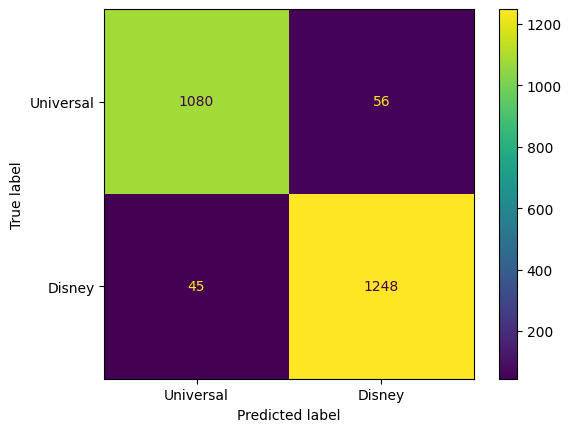

In [46]:
# Get predictions of Testing bootstrapped data
predictions3 = pipe3.predict(X_test_boot)

# Confusion matrix
dist = ConfusionMatrixDisplay(confusion_matrix(y_test_boot, predictions3), 
                       display_labels=['Universal', 'Disney'])
dist.plot()

In [47]:
# Set up the confusion matrix and extract individual score elements

tn3, fp3, fn3, tp3 = confusion_matrix(y_test_boot, predictions3).ravel()
print("True Negatives : ",tn3)
print("False Positives : ",fp3)
print("False Negatives : ", fn3) 
print("True Positives : ", tp3)

True Negatives :  1080
False Positives :  56
False Negatives :  45
True Positives :  1248


In [48]:
# Obtain Sensitivity score
print('Sensitivity: ', (tp3/(tp3+fn3)).round(2))

Sensitivity:  0.97


In [49]:
# Obtain Specificity score
print('Specificity: ', (tn3/(tn3+fp3)).round(2))

Specificity:  0.95


In [50]:
# Set up classification report

print(classification_report(y_test_boot, predictions3))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1136
           1       0.96      0.97      0.96      1293

    accuracy                           0.96      2429
   macro avg       0.96      0.96      0.96      2429
weighted avg       0.96      0.96      0.96      2429



In [51]:
# Set up a dataframe of y_test, prediction, and X_test columns
result_df3 = pd.DataFrame({'true':y_test_boot, 'pred':predictions3, 'post': X_test_boot})

# Set missprediction where y_test is not equal to prediction
missprediction3 = result_df3[result_df3['true']!=result_df3['pred']]
print(missprediction3)

# Save missprediction to csv file
missprediction3.to_csv('missed_predictions3.csv', index=False)

      true  pred                                               post
468      1     0  hi all :) \n\n\n my girlfriend and I be plan o...
1729     1     0  so I want to buy they online to skip the ticke...
4172     0     1  what be some non - dessert snack credit option...
2318     1     0  and have pin . I be just over by ticket buildi...
2057     1     0  hi everyone , \n\n\n I have be look off and on...
...    ...   ...                                                ...
71       1     0  my friend and I have park hopper pass for this...
1666     1     0  hello my fellow er ! \n\n\n as some of you may...
4564     0     1  post in hope that someone that have pull at th...
3966     0     1  my wife and I be head to   Jan 24 - 26 . we be...
2922     1     0  pretty simple question . I could n't find an a...

[101 rows x 3 columns]


In [95]:
# Set up a DataFrame 'result_df3' with columns 'true' for y_test, 'pred' for predictions, and 'post' for X_test
result_df3 = pd.DataFrame({'true': y_test_boot, 'pred': predictions3, 'post': X_test_boot})

# Set missprediction where y_test is not equal to prediction
missprediction3 = result_df3[result_df3['true'] != result_df3['pred']]

# Print the DataFrame containing mispredictions
print("Mispredictions:")
print(missprediction3)

# Print the full content of the 'post' column in mispredictions
print("\nFull 'post' content of Mispredictions:")
for post_content in missprediction3['post']:
    print(post_content)

Mispredictions:
      true  pred                                               post
468      1     0  hi all :) \n\n\n my girlfriend and I be plan o...
1729     1     0  so I want to buy they online to skip the ticke...
4172     0     1  what be some non - dessert snack credit option...
2318     1     0  and have pin . I be just over by ticket buildi...
2057     1     0  hi everyone , \n\n\n I have be look off and on...
...    ...   ...                                                ...
71       1     0  my friend and I have park hopper pass for this...
1666     1     0  hello my fellow er ! \n\n\n as some of you may...
4564     0     1  post in hope that someone that have pull at th...
3966     0     1  my wife and I be head to   Jan 24 - 26 . we be...
2922     1     0  pretty simple question . I could n't find an a...

[101 rows x 3 columns]

Full 'post' content of Mispredictions:
hi all :) 


 my girlfriend and I be plan on go to   may 12 - 18 to celebrate our 2 year and my graduati

**Incorrectly predicted post analysis**
- The contents are mainly irrelevant to any subreddits, did not mention any keywords that could identify as Disneyland or Universal Studios

**Model Evaluation**
- Training score: 1 indicates that the model learned the patterns present in the data perfectly
- Testing score: 0.96 indicates the model is able to perform very well on outside data
- The model is not overfit and have a close performance between training data and testing data
- Precision score: 0.96 and 0.96 indicates the model correctly predicts the class: Universal 96% and class: Disneyland 96% of the time
- Recall score: 0.95 and 0.97 indicates that the model is able to identify the actual values of class: Universal 95% and class: Disneyland 97% of the time
- F1 score: 0.96 and 0.96 indicates the model well balanced performance on both precision and recall and the score are matched between these 2 classes.
- Accuracy score: 0.96 indicates the the model is highly accurate
- Macro avg and Weighted avg: 0.96 and 0.96 indicates high performance of the model
- Incorrectly predict: Universal 4% Disney 6%
- Out of 2429 posts, 101 posts are incorrectly predicted: 4.16%

**Final Evaluation**
- Random Forest performance is better than Logistic Regression since Random Forest is a high-complexed model that works well with complexed data, reduce data overfitting, and robust to outliers.
- Performance has been improved in both Universal and Disney classes
- Universal precision score is 0.1 higher than Disney resulting in higher correct prediction

## Model4: TfidfVectorizer + RandomForestClassifier

In [52]:
# Set up the pipeline of TfidfVectorizer and Random Forest Classifier combined with parameters obtained from GridSearch 
pipe4 = Pipeline([
    ('tvec', TfidfVectorizer(max_df=0.9, max_features=5000, min_df=2, ngram_range= (1,1), stop_words='english')),
    ('rf', RandomForestClassifier(max_depth=None, n_estimators=100))])


In [53]:
# Fit the pipeline to Training bootstrapped data
pipe4.fit(X_train_boot, y_train_boot)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, max_features=5000, min_df=2,
                                 stop_words='english')),
                ('rf', RandomForestClassifier())])

In [54]:
# Retrieve the accuracy score of Training bootstrapped data
pipe4.score(X_train_boot, y_train_boot).round(2)

1.0

In [55]:
# Retrieve the accuracy score of Testing bootstrapped data
pipe4.score(X_test_boot, y_test_boot).round(2)

0.96

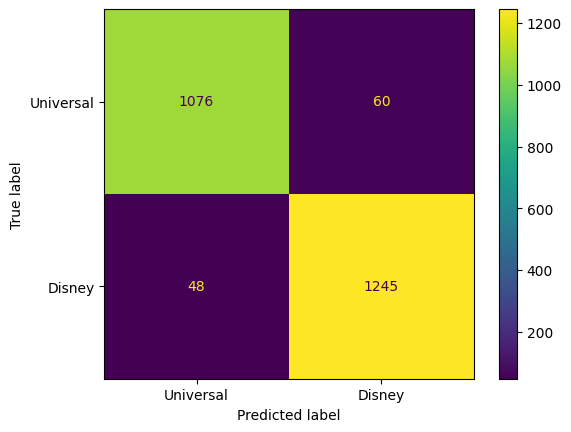

In [56]:
# Get predictions of Testing bootstrapped data
predictions4 = pipe4.predict(X_test_boot)

# Set up confusion matrix
dist = ConfusionMatrixDisplay(confusion_matrix(y_test_boot, predictions4), 
                       display_labels=['Universal', 'Disney'])
dist.plot()

In [57]:
# Set up the confusion matrix and extract individual score elements

tn4, fp4, fn4, tp4 = confusion_matrix(y_test_boot, predictions4).ravel()
print("True Negatives : ",tn4)
print("False Positives : ",fp4)
print("False Negatives : ", fn4) 
print("True Positives : ", tp4)

True Negatives :  1076
False Positives :  60
False Negatives :  48
True Positives :  1245


In [58]:
# Obtain Sensitivity score
print('Sensitivity: ', (tp4/(tp4+fn4)).round(2))

Sensitivity:  0.96


In [59]:
# Obtain Specificity score
print('Specificity: ', (tn4/(tn4+fp4)).round(2))

Specificity:  0.95


In [60]:
# Set up classification report
print(classification_report(y_test_boot, predictions4))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1136
           1       0.95      0.96      0.96      1293

    accuracy                           0.96      2429
   macro avg       0.96      0.96      0.96      2429
weighted avg       0.96      0.96      0.96      2429



In [61]:
# Set up a dataframe of y_test, prediction, and X_test columns
result_df4 = pd.DataFrame({'true':y_test_boot, 'pred':predictions4, 'post': X_test_boot})

# Set missprediction where y_test is not equal to prediction
missprediction4 = result_df4[result_df4['true']!=result_df4['pred']]
print(missprediction4)

# Save missprediction to csv file
missprediction4.to_csv('missed_predictions5.csv', index=False)

      true  pred                                               post
1729     1     0  so I want to buy they online to skip the ticke...
4172     0     1  what be some non - dessert snack credit option...
4340     0     1  hello premier pass holder , \n\n\n have anyone...
5267     0     1  plan on visit the park on Saturday . anyone kn...
2057     1     0  hi everyone , \n\n\n I have be look off and on...
...    ...   ...                                                ...
1666     1     0  hello my fellow er ! \n\n\n as some of you may...
3975     0     1  I be interested in do the Gringotts ride but b...
4564     0     1  post in hope that someone that have pull at th...
3966     0     1  my wife and I be head to   Jan 24 - 26 . we be...
2922     1     0  pretty simple question . I could n't find an a...

[108 rows x 3 columns]


**Model Evaluation**
- Training score: 1 indicates that the model learned the patterns present in the data perfectly
- Testing score: 0.96 indicates the model is able to perform very well on outside data
- The model is not overfit and have a close performance between training data and testing data
- Precision score: 0.96 and 0.95 indicates the model correctly predicts the class: Universal 96% and class: Disneyland 95% of the time
- Recall score: 0.95 and 0.96 indicates that the model is able to identify the actual values of class: Universal 95% and class: Disneyland 96% of the time
- F1 score: 0.95 and 0.96 indicates the model well balanced performance on both precision and recall and the score are close between these 2 classes.
- Accuracy score: 0.96 indicates the the model is highly accurate
- Macro avg and Weighted avg: 0.96 and 0.96 indicates high performance of the model
- Incorrectly predict: Universal 2.6% Disney 5.9%
- Out of 2429 posts, 108 posts are incorrectly predicted: 4.45%

**Final Evaluation**
- Combining TfidfVectorizer with Random Forest does not improve the performance of the model, even though TfidfVectorizer considers both frequency of the words and the importance of the words within the context, in contrast to CountVectorizer which only consider the frequency of the words.


## Model5: CountVectorizer + MultinomialNB

In [62]:
# Set up the pipeline of CountVecotizer and Multinomial Naive Bayes combined with parameters obtained from GridSearch 

pipe5 = Pipeline([
    ('cvec', CountVectorizer(max_df=0.95, max_features=5000, min_df=2, ngram_range=(1,1), stop_words='english')),
    ('nb', MultinomialNB())])


In [63]:
#gs5 = GridSearchCV(pipe5, 
                  #param_grid=pipe5_params, 
                  #cv=5,
                  #verbose=1)

In [64]:
# Fit the pipeline to Training bootstrapped data

pipe5.fit(X_train_boot, y_train_boot)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.95, max_features=5000, min_df=2,
                                 stop_words='english')),
                ('nb', MultinomialNB())])

In [65]:
#pipe5.best_score_

In [66]:
#pipe5.best_params_

In [67]:
# Retrieve the accuracy score of Training bootstrapped data

pipe5.score(X_train_boot, y_train_boot).round(2)

0.95

In [68]:
# Retrieve the accuracy score of Testing bootstrapped data

pipe5.score(X_test_boot, y_test_boot).round(2)

0.92

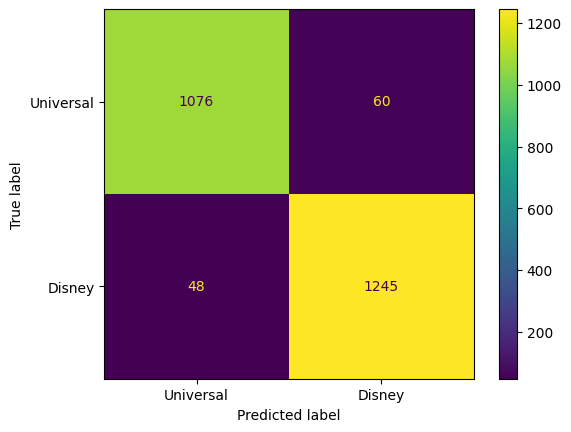

In [69]:
# Get predictions of Testing data
predictions5 = pipe5.predict(X_test_boot)

# Set up confusion matrix
dist = ConfusionMatrixDisplay(confusion_matrix(y_test_boot, predictions4), 
                       display_labels=['Universal', 'Disney'])
dist.plot()

In [70]:
# Set up the confusion matrix and extract individual score elements

tn5, fp5, fn5, tp5 = confusion_matrix(y_test_boot, predictions5).ravel()
print("True Negatives : ",tn5)
print("False Positives : ",fp5)
print("False Negatives : ", fn5) 
print("True Positives : ", tp5)

True Negatives :  1074
False Positives :  62
False Negatives :  121
True Positives :  1172


In [71]:
# Obtain Sensitivity score
print('Sensitivity: ', (tp5/(tp5+fn5)).round(2))

Sensitivity:  0.91


In [72]:
# Obtain Specificity score
print('Specificity: ', (tn5/(tn5+fp5)).round(2))

Specificity:  0.95


In [73]:
# Set up classification report

print(classification_report(y_test_boot, predictions5))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1136
           1       0.95      0.91      0.93      1293

    accuracy                           0.92      2429
   macro avg       0.92      0.93      0.92      2429
weighted avg       0.93      0.92      0.92      2429



In [74]:
# Set up a dataframe of y_test, prediction, and X_test columns
result_df5 = pd.DataFrame({'true':y_test_boot, 'pred':predictions5, 'post': X_test_boot})

# Set missprediction where y_test is not equal to prediction
missprediction5 = result_df5[result_df5['true']!=result_df5['pred']]
print(missprediction4)

# Save missprediction to csv file
missprediction5.to_csv('missed_predictions5.csv', index=False)

      true  pred                                               post
1729     1     0  so I want to buy they online to skip the ticke...
4172     0     1  what be some non - dessert snack credit option...
4340     0     1  hello premier pass holder , \n\n\n have anyone...
5267     0     1  plan on visit the park on Saturday . anyone kn...
2057     1     0  hi everyone , \n\n\n I have be look off and on...
...    ...   ...                                                ...
1666     1     0  hello my fellow er ! \n\n\n as some of you may...
3975     0     1  I be interested in do the Gringotts ride but b...
4564     0     1  post in hope that someone that have pull at th...
3966     0     1  my wife and I be head to   Jan 24 - 26 . we be...
2922     1     0  pretty simple question . I could n't find an a...

[108 rows x 3 columns]


**Model Evaluation**
- Training score: 0.95 indicates that the model learned the patterns present in the data perfectly
- Testing score: 0.92 indicates the model is able to perform very well on outside data
- The model is not overfit and have a close performance between training data and testing data
- Precision score: 0.90 and 0.95 indicates the model correctly predicts the class: Universal 90% and class: Disneyland 95% of the time
- Recall score: 0.95 and 0.91 indicates that the model is able to identify the actual values of class: Universal 95% and class: Disneyland 91% of the time
- F1 score: 0.92 and 0.93 indicates the model well balanced performance on both precision and recall and the score are closed between these 2 classes.
- Accuracy score: 0.92 indicates the the model is highly accurate
- Macro avg and Weighted avg: 0.92 and 0.92 indicates high performance of the model
- Incorrectly predict: Universal 10% Disney 5%
- Out of 2429 posts, 108 posts are incorrectly predicted: 4.44%

**Final Evaluation**
- Multinomial Naive Bayes is commonly used in natural language processing and text classification, so this model is appropriate for this text data. 
- When comparing to the performance of Random Forest Classifier, the performance is not as good as Random Forest

## Model 6: TfidfVectorizer + MultinomialNB

In [75]:
# Set up the pipeline of TfidfVectorizer and Multinomial Naive Bayes combined with parameters obtained from GridSearch 
pipe6 = Pipeline([
    ('tvec', TfidfVectorizer(max_df=0.9, max_features=5000, min_df=2, ngram_range= (1,1), stop_words='english')),
    ('nb',  MultinomialNB())])

In [76]:
#gs6 = GridSearchCV(pipe6, 
                  #param_grid=pipe6_params, 
                  #cv=5,
                  #verbose=1)

In [77]:
# Fit the pipeline to Training bootstrapped data
pipe6.fit(X_train_boot, y_train_boot)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, max_features=5000, min_df=2,
                                 stop_words='english')),
                ('nb', MultinomialNB())])

In [78]:
#gs6.best_score_

In [79]:
#gs6.best_params_

In [80]:
# Retrieve the accuracy score of Training bootstrapped data
pipe6.score(X_train_boot, y_train_boot).round(2)

0.96

In [81]:
# Retrieve the accuracy score of Testing bootstrapped data
pipe6.score(X_test_boot, y_test_boot).round(2)

0.93

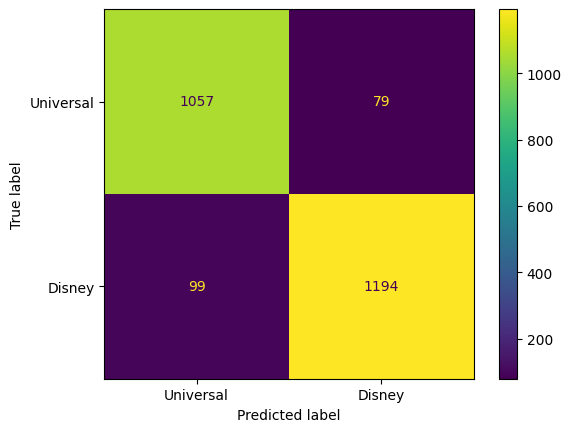

In [82]:
# Get predictions of Testing data
predictions6 = pipe6.predict(X_test_boot)

# Set up confusion matrix
dist = ConfusionMatrixDisplay(confusion_matrix(y_test_boot, predictions6), 
                       display_labels=['Universal', 'Disney'])
dist.plot()

In [83]:
# Set up the confusion matrix and extract individual score elements

tn6, fp6, fn6, tp6 = confusion_matrix(y_test_boot, predictions6).ravel()
print("True Negatives : ",tn6)
print("False Positives : ",fp6)
print("False Negatives : ", fn6) 
print("True Positives : ", tp6)

True Negatives :  1057
False Positives :  79
False Negatives :  99
True Positives :  1194


In [84]:
# Obtain Sensitivity score
print('Sensitivity: ', (tp6/(tp6+fn6)).round(2))

Sensitivity:  0.92


In [85]:
# Obtain Specificity score
print('Specificity: ', (tn6/(tn6+fp6)).round(2))

Specificity:  0.93


In [86]:
# Set up classification report

print(classification_report(y_test_boot, predictions6))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1136
           1       0.94      0.92      0.93      1293

    accuracy                           0.93      2429
   macro avg       0.93      0.93      0.93      2429
weighted avg       0.93      0.93      0.93      2429



In [87]:
# Set up a dataframe of y_test, prediction, and X_test columns
result_df6 = pd.DataFrame({'true':y_test_boot, 'pred':predictions6, 'post': X_test_boot})

# Set missprediction where y_test is not equal to prediction
missprediction6 = result_df6[result_df6['true']!=result_df6['pred']]
print(missprediction6)

# Save missprediction to csv file
missprediction5.to_csv('missed_predictions6.csv', index=False)

      true  pred                                               post
5255     0     1  link to post with Dropbox link from corporate ...
5344     0     1  go next week - stay within a reasonable walk o...
1669     1     0  hi all - \n\n\n my wife & I be take our daught...
468      1     0  hi all :) \n\n\n my girlfriend and I be plan o...
1446     1     0  Hi , all ! \n\n\n I have n't be to the park in...
...    ...   ...                                                ...
4570     0     1  hello ! \n\n\n I be go to be go to   Hollywood...
4564     0     1  post in hope that someone that have pull at th...
2922     1     0  pretty simple question . I could n't find an a...
178      1     0  hey guy , \n\n\n I go to   last weekend with m...
5057     0     1  as more footage from Super Nintendo World in U...

[178 rows x 3 columns]


**Model Evaluation**
- Training score: 0.96 indicates that the model learned the patterns present in the data very well
- Testing score: 0.93 indicates the model is able to perform very well on outside data
- The model is not overfit and have a close performance between training data and testing data
- Precision score: 0.91 and 0.94 indicates the model correctly predicts the class: Universal 91% and class: Disneyland 94% of the time
- Recall score: 0.93 and 0.92 indicates that the model is able to identify the actual values of class: Universal 93% and class: Disneyland 92% of the time
- F1 score: 0.92 and 0.93 indicates the model well balanced performance on both precision and recall and the score are closed between these 2 classes.
- Accuracy score: 0.93 indicates the the model is highly accurate
- Macro avg and Weighted avg: 0.93 and 0.93 indicates high performance of the model
- Incorrectly predict: Universal 7% Disney 7%
- Out of 2429 posts, 169 posts are incorrectly predicted: 7.33%

**Final Evaluation**
- Combining TfidfVectorizer with Multinomial Naives Bayes to compare the performance with CountVectorizer performance, where TfidfVectorizer considers both the frequency of the words and the rarity of across the entire corpus
- When comparing to the performance of CountVectorizer + Multinomial Naives Bayes, the performance is close, however; CountVectorizer outperforms in the accuracy of the prediction

**Final Model Evaluation**
- 

- The most optimal model is CountVectorizer + Random Forest Classifier, this model yields the best score of all and has the least amount of incorrect prediction
- Disneyland is more popular than Universal Studios because of the higher posts received and more votes received, this means more public interest and engagement
- Disneyland's post tone is also neutral/positive
- Promotional tactics will be targeted toward Disneyland since more popular means more demand, which increases customer satisfaction